In [1]:
from pathlib import Path

def find_corresponding_scan(segmention_path):
    scan_folder = Path(segmention_path).parent.parent / "scans"
    scan_name = Path(segmention_path).name.split(".")[0][:-2] + ".nii.gz"

    return scan_folder / scan_name


segmentation_path = r"D:\premium_data\amphia\monotherapy\split_segmentations\PREM_AM_001_0.nii.gz"
scan_path = find_corresponding_scan(segmentation_path)

data = {"img": str(scan_path), "seg": str(segmentation_path)}

In [5]:
from src.transforms import (
    FindCentroid,
    GetFixedROISize,
    CropToCentroidWithSize,
    PadForCrop,
    Save,
    OrthogonalSlices,
    CropToROI,
    GetZoomedROI,
    PadForZoom
)

from monai.transforms import Identityd, Compose, LoadImaged, EnsureChannelFirstd, Resized, ScaleIntensityRanged

class CropPreprocessor:
    def __init__(self, output_root_folder, roi_size, output_size, output_dim):
        self.output_root_folder = output_root_folder
        self.roi_size = roi_size
        self.output_size = output_size

        assert output_dim in [2,3]
        self.output_dim = output_dim

        self.make_pipeline()

    def make_pipeline(self):
        self.pipeline = Compose([
            LoadImaged(keys=["img", "seg"]),
            EnsureChannelFirstd(keys=["img", "seg"]),
            self.get_roi_selection_pipeline(),
            Resized(keys=["img"], spatial_size=[self.output_size] * 3),
            ScaleIntensityRanged(
                keys=["img"], a_min=-1024, a_max=3000, b_min=0, b_max=1, clip=True
            ),
            self.get_dimensionality_selection(),
            Save(output_dir=self.output_root_folder),
        ])

    # def get_roi_selection_pipeline(self):
    #     return Compose([
    #         FindCentroid(),
    #         GetFixedROISize(self.roi_size),
    #         CropPad(),
    #         CropToROI(),
    #     ])

    def get_roi_selection_pipeline(self):
        return Compose([
            GetZoomedROI(0),
            PadForZoom(),
            CropToROI()
        ])

    def get_dimensionality_selection(self):
        if self.output_dim == 2:
            return OrthogonalSlices()
        else:
            return Identityd(keys=['img','seg'])

    def __call__(self, data):
        return self.pipeline(data)

In [ ]:
class Preprocessor:
    def __init__(self, output_folder, output_dim, output_size):
        self.output_folder = output_folder
        self.output_size = output_size

        assert output_dim in [2,3]
        self.output_dim = output_dim

    def make_pipeline(self):
        self.pipeline = Compose([
            LoadImaged(keys=["img", "seg"]),
            EnsureChannelFirstd(keys=["img", "seg"]),
            self.roi_selection_pipeline,
            Resized(keys=["img"], spatial_size=[self.output_size] * 3),
            ScaleIntensityRanged(
                keys=["img"], a_min=-1024, a_max=3000, b_min=0, b_max=1, clip=True
            ),
            self.get_dimensionality_selection(),
            Save(output_dir=self.output_root_folder),
        ])

    def get_roi_selection_pipeline():
        pass

    def get_dimensionality_selection(self):
        if self.output_dim == 2:
            return OrthogonalSlices()
        else:
            return Identityd(keys=['img','seg'])

    def __call__(self, data):
        return self.pipeline(data)


class CropPreprocessor(Preprocessor):
    def __init__(self, output_folder, output_dim, output_size, roi_size):
        super().__init__(output_folder, output_dim, output_size)

        self.roi_selection_pipeline = Compose([
            FindCentroid(),
            GetFixedROISize(roi_size),
            CropPad(),
            CropToROI(),
        ])

class ZoomPreprocessor(Preprocessor):
    def __init__(self, output_folder, output_dim, output_size, margin):
        super().__init__(output_folder, output_dim, output_size)
        self.margin = margin

        self.roi_selection_pipeline = Compose([
            GetZoomedROI(margin),
            PadForZoom(),
            CropToROI()
        ])

In [6]:
pipeline = CropPreprocessor(None, None, 128, 2)
output = pipeline(data)

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


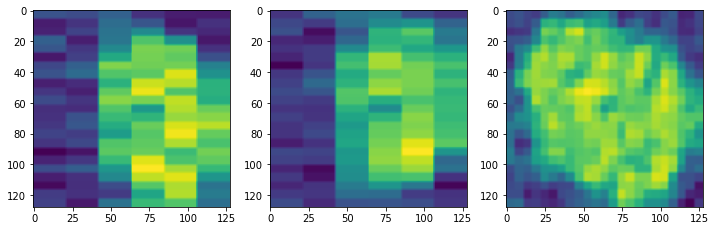

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(12,4))
for ix in range(3):
    ax[ix].imshow(output['img'][ix])
fig.show()

In [76]:
import torch

where = torch.where(output['seg'])[1:]
bbox_min_coordinates = np.array([axis.min() for axis in where])
bbox_max_coordinates = np.array([axis.max() for axis in where])
bbox_dim = bbox_max_coordinates - bbox_min_coordinates

pix_size = output['seg'].affine.diag().numpy()[:-1]
bbox_size = bbox_dim * pix_size

margin = 5
roi_size = bbox_size.max() + margin

roi_dim = roi_size / pix_dim
margin_to_add = (roi_dim - bbox_dim) / 2
roi_min_coordinates = (bbox_min_coordinates - margin_to_add).astype(int)
roi_max_coordinates = (bbox_max_coordinates + margin_to_add).astype(int)

In [79]:
class GetZoomedROI(Transform):
    def __init__(self, margin=10):
        super().__init__()
        self.margin = margin

    def __call__(self, data):
        where = torch.where(data['seg'])[1:]
        bbox_min_coordinates = np.array([axis.min() for axis in where])
        bbox_max_coordinates = np.array([axis.max() for axis in where])
        bbox_dim = bbox_max_coordinates - bbox_min_coordinates

        pix_size = data['seg'].affine.diag().numpy()[:-1]
        bbox_size = bbox_dim * pix_size

        margin = 5
        roi_size = bbox_size.max() + margin

        roi_dim = roi_size / pix_dim
        margin_to_add = (roi_dim - bbox_dim) / 2
        roi_min_coordinates = (bbox_min_coordinates - margin_to_add).astype(int)
        roi_max_coordinates = (bbox_max_coordinates + margin_to_add).astype(int)

        data['roi_start'] = roi_min_coordinates
        data['roi_stop'] = roi_max_coordinates
        data['pix_margin'] = np.ceil(margin_to_add).astype(int)

        return data
        

class PadForZoom(Transform):
    def __call__(self, data):
        padder = BorderPad(data['pix_margin'], value=-1024)
        data['img'] = padder(data['img'])
        data['roi_start'] = data['roi_start'] + data['pix_margin']
        data['roi_stop'] = data['roi_stop'] + data['pix_margin']

        return data

        

array([21.97265625, 21.97265625, 24.        ])

NameError: name 'bbox_min_coordinates' is not defined

In [52]:
np.array([xmin, xmax, ymin, ymax, zmin, zmax])

pix_dim = np.array([
    xmax-xmin,
    ymax-ymin,
    zmax-zmin
])
pix_dim * output['seg'].affine.diag().numpy()[:-1]

array([16.84570312, 16.84570312,  9.        ])

In [50]:
output['seg'].affine.diag()[:-1]

tensor([0.7324, 0.7324, 3.0000], dtype=torch.float64)

tensor([[[0.2322, 0.2322, 0.2333,  ..., 0.2795, 0.2826, 0.2826],
         [0.2289, 0.2289, 0.2307,  ..., 0.2802, 0.2818, 0.2818],
         [0.2270, 0.2270, 0.2292,  ..., 0.2862, 0.2857, 0.2857],
         ...,
         [0.0518, 0.0518, 0.0566,  ..., 0.1306, 0.1323, 0.1323],
         [0.0214, 0.0214, 0.0220,  ..., 0.0304, 0.0306, 0.0306],
         [0.0239, 0.0239, 0.0229,  ..., 0.0214, 0.0198, 0.0198]],

        [[0.2218, 0.2218, 0.2239,  ..., 0.2344, 0.2208, 0.2208],
         [0.2229, 0.2229, 0.2246,  ..., 0.2437, 0.2397, 0.2397],
         [0.2222, 0.2222, 0.2227,  ..., 0.2444, 0.2465, 0.2465],
         ...,
         [0.2273, 0.2273, 0.2250,  ..., 0.2547, 0.2506, 0.2506],
         [0.2249, 0.2249, 0.2230,  ..., 0.2539, 0.2517, 0.2517],
         [0.2294, 0.2294, 0.2271,  ..., 0.2567, 0.2529, 0.2529]],

        [[0.2218, 0.2218, 0.2239,  ..., 0.2344, 0.2208, 0.2208],
         [0.2229, 0.2229, 0.2246,  ..., 0.2437, 0.2397, 0.2397],
         [0.2222, 0.2222, 0.2227,  ..., 0.2444, 0.2465, 0.